In [1]:

import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
xl = pd.ExcelFile("pathway-tf-final.xlsx")
df = xl.parse("Sheet1")
# df.columns=["pathway","tfs"]
# df=df.head()
df

Term name  Adjusted p-value  \
0                         acute myeloid leukemia          0.009716   
1                adipocytokine signaling pathway          0.009716   
2                              pancreatic cancer          0.009716   
3                     jak stat signaling pathway          0.014745   
4                         acute myeloid leukemia          0.009716   
...                                          ...               ...   
1048570                               cell cycle          0.235056   
1048571                           focal adhesion          0.381879   
1048572  neuroactive ligand receptor interaction          0.437467   
1048573                          prostate cancer          0.000002   
1048574                        pancreatic cancer          0.000010   

                                                   cascade  
0                                       ['STAT3', 'PRDM1']  
1                                       ['STAT3', 'PRDM1']  
2                                       ['STAT3', 'PRDM1']  
3                                       ['STAT3', 'PRDM1']  
4                                        ['STAT3', 'KLF5']  
...                                                    ...  
1048570  ['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...  
1048571  ['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...  
1048572  ['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...  
1048573  ['SMAD4', 'TBX18', 'SNAI2', 'STAT1', 'TBX21', ...  
1048574  ['SMAD4', 'TBX18', 'SNAI2', 'STAT1', 'TBX21', ...  

[1048575 rows x 3 columns]

In [3]:
# df.tfs[1].__class__

In [4]:
df1=df


In [5]:
df=df1

In [6]:
import ast
df.columns=["pathway", "weight", "tfs"]
cols=['tfs','pathway', 'weight']
df["weight"] = pd.to_numeric(df["weight"])
df = df[cols]
df['tfs_copy'] = df['tfs']
df['tfs_copy'] = df['tfs_copy'].apply(lambda s: list(ast.literal_eval(s)))
df['tfs'] = df['tfs'].astype('category')
print(df.dtypes)
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
df

/scratch/slurm-261690/ipykernel_30866/1339310708.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tfs_copy'] = df['tfs']
/scratch/slurm-261690/ipykernel_30866/1339310708.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tfs_copy'] = df['tfs_copy'].apply(lambda s: list(ast.literal_eval(s)))


tfs         category
pathway       object
weight       float64
tfs_copy      object
dtype: object


/scratch/slurm-261690/ipykernel_30866/1339310708.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tfs'] = df['tfs'].astype('category')
/ihome/yanshanwang/sos86/.local/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


tfs                                  pathway    weight  \
0        8775                   acute myeloid leukemia  0.009716   
1        8775          adipocytokine signaling pathway  0.009716   
2        8775                        pancreatic cancer  0.009716   
3        8775               jak stat signaling pathway  0.014745   
4        8333                   acute myeloid leukemia  0.009716   
...       ...                                      ...       ...   
1048570  2930                               cell cycle  0.235056   
1048571  2930                           focal adhesion  0.381879   
1048572  2930  neuroactive ligand receptor interaction  0.437467   
1048573  6647                          prostate cancer  0.000002   
1048574  6647                        pancreatic cancer  0.000010   

                                                  tfs_copy  
0                                           [STAT3, PRDM1]  
1                                           [STAT3, PRDM1]  
2                                           [STAT3, PRDM1]  
3                                           [STAT3, PRDM1]  
4                                            [STAT3, KLF5]  
...                                                    ...  
1048570  [LEF1, MYC, SNAI1, NANOG, POU5F1, STAT3, TWIST...  
1048571  [LEF1, MYC, SNAI1, NANOG, POU5F1, STAT3, TWIST...  
1048572  [LEF1, MYC, SNAI1, NANOG, POU5F1, STAT3, TWIST...  
1048573  [SMAD4, TBX18, SNAI2, STAT1, TBX21, RUNX3, EGR...  
1048574  [SMAD4, TBX18, SNAI2, STAT1, TBX21, RUNX3, EGR...  

[1048575 rows x 4 columns]

In [7]:
var=df.tfs_copy.values[1]
# var=var.strip('[]').split(',')
print(var)
type(var)

['STAT3', 'PRDM1']


list

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('tfs_copy')),
                index=df.index,
                columns=mlb.classes_))
df

tfs                                  pathway    weight  AHR  ALX1  \
0        8775                   acute myeloid leukemia  0.009716    0     0   
1        8775          adipocytokine signaling pathway  0.009716    0     0   
2        8775                        pancreatic cancer  0.009716    0     0   
3        8775               jak stat signaling pathway  0.014745    0     0   
4        8333                   acute myeloid leukemia  0.009716    0     0   
...       ...                                      ...       ...  ...   ...   
1048570  2930                               cell cycle  0.235056    0     0   
1048571  2930                           focal adhesion  0.381879    0     0   
1048572  2930  neuroactive ligand receptor interaction  0.437467    0     0   
1048573  6647                          prostate cancer  0.000002    0     0   
1048574  6647                        pancreatic cancer  0.000010    0     0   

         ALX4  AR  ARID2  ARID3A  ARID5B  ...  ZBTB7B  ZEB1  ZEB2  ZFP57  \
0           0   0      0       0       0  ...       0     0     0      0   
1           0   0      0       0       0  ...       0     0     0      0   
2           0   0      0       0       0  ...       0     0     0      0   
3           0   0      0       0       0  ...       0     0     0      0   
4           0   0      0       0       0  ...       0     0     0      0   
...       ...  ..    ...     ...     ...  ...     ...   ...   ...    ...   
1048570     0   0      0       0       0  ...       0     0     0      0   
1048571     0   0      0       0       0  ...       0     0     0      0   
1048572     0   0      0       0       0  ...       0     0     0      0   
1048573     0   1      0       0       0  ...       0     0     0      0   
1048574     0   1      0       0       0  ...       0     0     0      0   

         ZHX1  ZIC3  ZNF281  ZNF385A  ZNF423  ZNF467  
0           0     0       0        0       0       0  
1           0     0       0        0       0       0  
2           0     0       0        0       0       0  
3           0     0       0        0       0       0  
4           0     0       0        0       0       0  
...       ...   ...     ...      ...     ...     ...  
1048570     0     0       0        0       0       0  
1048571     0     0       0        0       0       0  
1048572     0     0       0        0       0       0  
1048573     0     0       0        0       0       0  
1048574     0     0       0        0       0       0  

[1048575 rows x 294 columns]

In [9]:
df_tf_cascadeid=df.loc[:, df.columns != 'pathway']
df_tf_cascadeid=df_tf_cascadeid.loc[:, df_tf_cascadeid.columns != 'weight']
df_tf_cascadeid = df_tf_cascadeid.set_index("tfs")
df_tf_cascadeid.index.name = None
df_tf_cascadeid = df_tf_cascadeid.drop_duplicates(subset=None, keep="first", inplace=False)
df_tf_cascadeid


AHR  ALX1  ALX4  AR  ARID2  ARID3A  ARID5B  ARNTL  ASCL1  ASH1L  ...  \
8775    0     0     0   0      0       0       0      0      0      0  ...   
8333    0     0     0   0      0       0       0      0      0      0  ...   
7743    0     0     0   0      0       0       0      0      0      0  ...   
8828    0     0     0   0      0       0       0      0      0      0  ...   
8641    0     0     0   0      0       0       0      0      0      0  ...   
...   ...   ...   ...  ..    ...     ...     ...    ...    ...    ...  ...   
3004    0     0     0   1      0       0       0      0      1      0  ...   
9963    0     0     0   1      0       0       0      0      0      0  ...   
304     0     0     0   1      0       0       0      0      0      1  ...   
501     0     0     0   1      0       0       0      0      0      0  ...   
8025    0     0     0   0      0       0       0      0      0      0  ...   

      ZBTB7B  ZEB1  ZEB2  ZFP57  ZHX1  ZIC3  ZNF281  ZNF385A  ZNF423  ZNF467  
8775       0     0     0      0     0     0       0        0       0       0  
8333       0     0     0      0     0     0       0        0       0       0  
7743       0     0     0      0     0     0       0        0       0       0  
8828       0     0     0      0     0     0       0        0       0       0  
8641       0     0     0      0     0     0       0        0       0       0  
...      ...   ...   ...    ...   ...   ...     ...      ...     ...     ...  
3004       0     1     0      0     0     0       0        0       0       0  
9963       0     0     0      0     1     0       0        0       0       0  
304        0     0     0      0     0     0       0        0       0       0  
501        0     1     0      0     0     0       0        0       0       0  
8025       0     1     0      0     0     0       0        0       0       0  

[9517 rows x 291 columns]

In [10]:
df_tf_cascadeid2 = pd.concat([df_tf_cascadeid, df_tf_cascadeid.T]).fillna(0)
df_tf_cascadeid2 = df_tf_cascadeid2.reindex(df_tf_cascadeid2.columns)
df_tf_cascadeid2

0    1    2    3    4    5    6    7    8    9  ...  ZBTB7B  ZEB1  \
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...   ...   
ZIC3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
ZNF281   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
ZNF385A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
ZNF423   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
ZNF467   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   

         ZEB2  ZFP57  ZHX1  ZIC3  ZNF281  ZNF385A  ZNF423  ZNF467  
0         0.0    0.0   0.0   0.0     0.0      0.0     0.0     0.0  
1         0.0    0.0   0.0   0.0     0.0      0.0     0.0     0.0  
2         0.0    0.0   0.0   0.0     0.0      0.0     0.0     0.0  
3         0.0    0.0   0.0   0.0     0.0      0.0     0.0     0.0  
4         0.0    0.0   0.0   0.0     0.0      0.0     0.0     0.0  
...       ...    ...   ...   ...     ...      ...     ...     ...  
ZIC3      0.0    0.0   0.0   0.0     0.0      0.0     0.0     0.0  
ZNF281    0.0    0.0   0.0   0.0     0.0      0.0     0.0     0.0  
ZNF385A   0.0    0.0   0.0   0.0     0.0      0.0     0.0     0.0  
ZNF423    0.0    0.0   0.0   0.0     0.0      0.0     0.0     0.0  
ZNF467    0.0    0.0   0.0   0.0     0.0      0.0     0.0     0.0  

[9808 rows x 9808 columns]

In [11]:
graph = nx.from_numpy_matrix(df_tf_cascadeid2.values)

In [13]:
graph = nx.relabel_nodes(graph, dict(enumerate(df_tf_cascadeid2.columns)))

In [16]:
import pickle
pickle.dump(graph, open('/tmp/tf_cascadid_colour_label.txt', 'w'))

# graph = pickle.load(open('/tmp/tf_cascadid_colour_label.txt'))
# print dg.edges()

TypeError: write() argument must be str, not bytes

In [20]:
nx.write_gexf(graph, "tmp/gephi/tf_cascadid_colour_label.gexf")

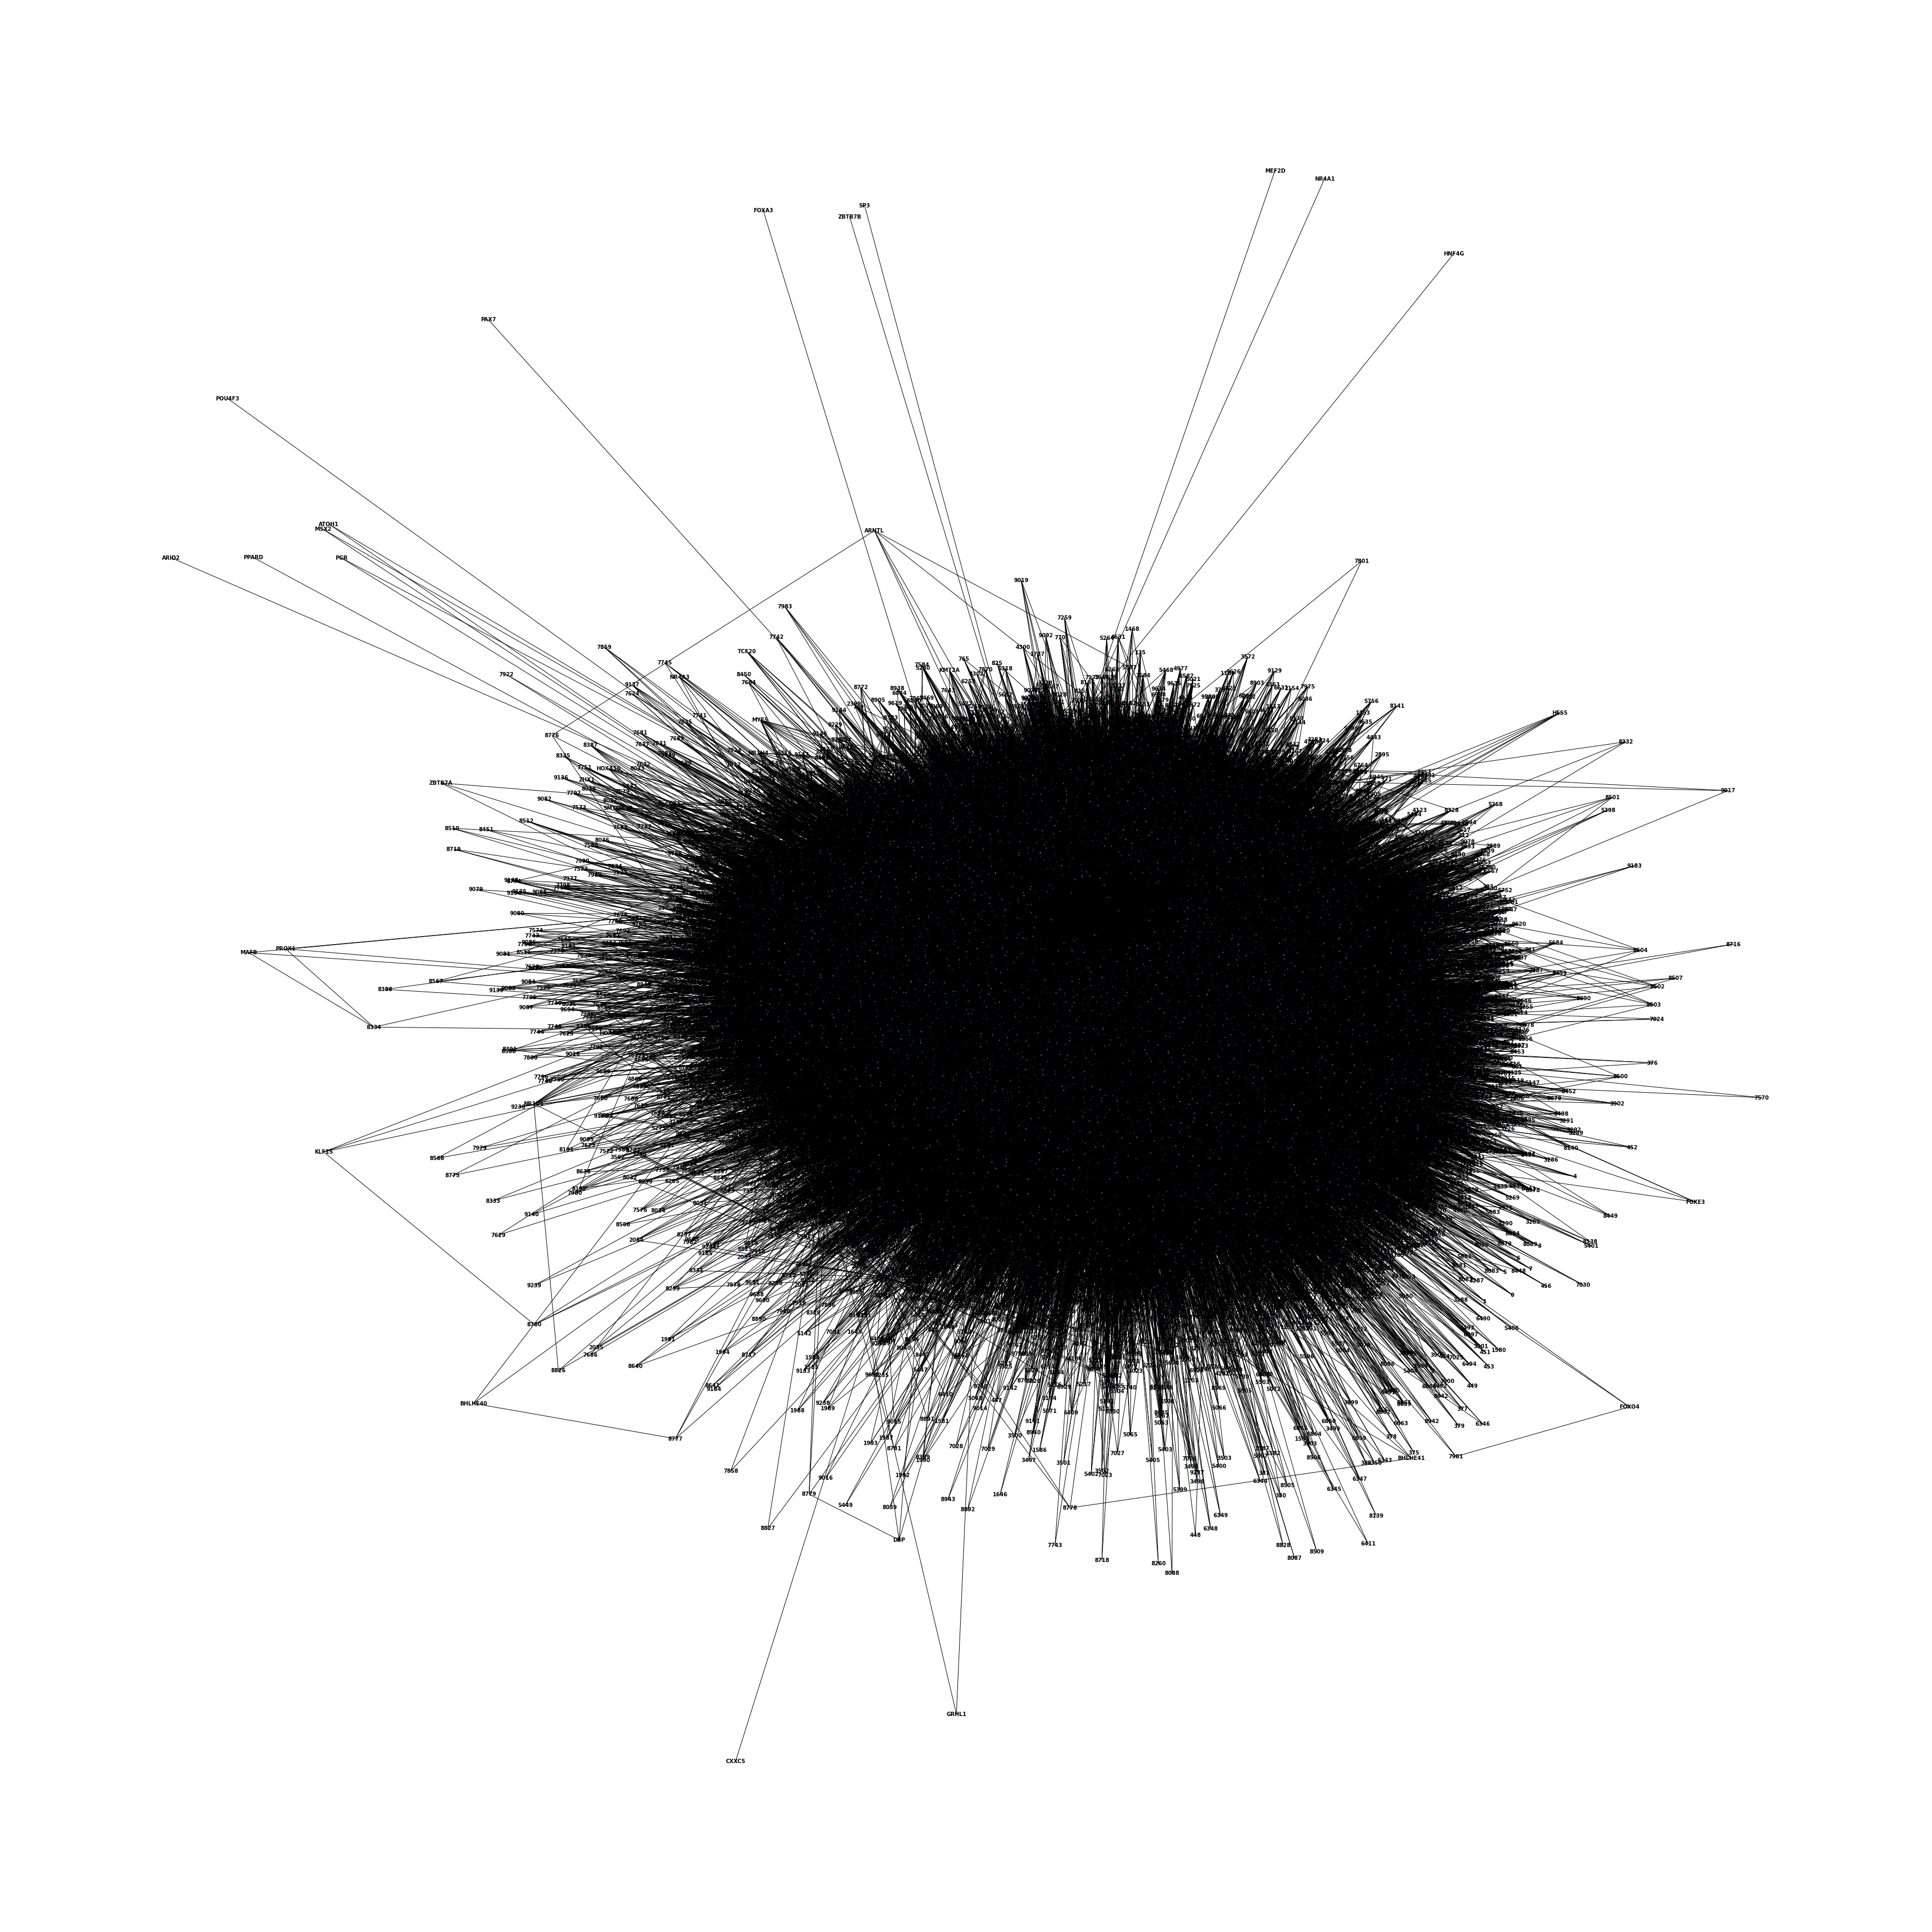

In [14]:
plt.figure(figsize=(50, 50))
# <Figure size 1500x1000 with 0 Axes>

nx.draw(graph, pos = nx.spring_layout(graph), \
    node_size=2,
    font_size=10, font_weight='bold', with_labels=True)
#linewidths=0.25
plt.savefig('tf_cascadid_colour_label.png')
plt.show()

In [24]:
df=df.drop_duplicates(subset=['pathway', 'tfs'], keep=False)
df.shape

(42918, 3)

# NETWORKX 1 - tf to cascade

In [7]:
import ast
df=df1
df.columns=["pathway", "weight", "tfs"]
cols=['tfs','pathway', 'weight']
df["weight"] = pd.to_numeric(df["weight"])
df = df[cols]
df['tfs_copy'] = df['tfs']
df=df.loc[:, df.columns != 'pathway']
df=df.loc[:, df.columns != 'weight']
df = df.drop_duplicates(subset=None, keep="first", inplace=False)
df['tfs_copy'] = df['tfs_copy'].apply(lambda s: list(ast.literal_eval(s)))
df['tfs'] = df['tfs'].astype('category')
print(df.dtypes)
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
df

/scratch/slurm-261646/ipykernel_19858/4242408243.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tfs_copy'] = df['tfs']


tfs         category
tfs_copy      object
dtype: object


tfs                                           tfs_copy
0       8775                                     [STAT3, PRDM1]
4       8333                                      [STAT3, KLF5]
8       7743                                     [STAT3, CEBPD]
12      8828                                      [STAT3, RORC]
16      8641                                     [STAT3, NANOG]
...      ...                                                ...
470253  9963  [ZHX1, EGR1, SNAI1, NANOG, POU5F1, SALL4, MYC,...
474338   304  [ASH1L, FOXP3, IRF8, SNAI1, NANOG, POU5F1, SAL...
476277  9217  [STAT3, ZEB1, AR, NANOG, POU5F1, SALL4, MYC, T...
479123   501  [ATF4, ATF3, STAT3, SALL4, NANOG, POU5F1, SNAI...
548545  8025  [STAT3, FOXO3, TP53, NANOG, POU5F1, SALL4, MYC...

[10000 rows x 2 columns]

In [8]:
# from sklearn.preprocessing import MultiLabelBinarizer

# mlb = MultiLabelBinarizer(sparse_output=True)

# df = df.join(
#             pd.DataFrame.sparse.from_spmatrix(
#                 mlb.fit_transform(df.pop('tfs_copy')),
#                 index=df.index,
#                 columns=mlb.classes_))
# df

In [9]:
df_tf_cascadeid=df
df_tf_cascadeid = df_tf_cascadeid.explode('tfs_copy')
df_tf_cascadeid = df_tf_cascadeid.rename({'tfs': 'target', 'tfs_copy': 'source'}, axis=1)

df_tf_cascadeid

target source
0         8775  STAT3
0         8775  PRDM1
4         8333  STAT3
4         8333   KLF5
8         7743  STAT3
...        ...    ...
548545    8025  SALL4
548545    8025    MYC
548545    8025  SNAI1
548545    8025   ZEB1
548545    8025   ETS1

[182867 rows x 2 columns]

In [10]:
df=df_tf_cascadeid

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(df, source='source', target='target', \
    create_using=nx.DiGraph)
colors = []
for node in G:
    if node in df["source"].values:
        colors.append("red")
    else: colors.append("blue")

# print(colors)
# ['lightblue', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen',
#  'lightblue', 'lightblue', 'lightgreen', 'lightblue', 'lightblue',
#  'lightblue', 'lightblue', 'lightgreen', 'lightgreen']

plt.figure(figsize=(50, 50))
# <Figure size 1500x1000 with 0 Axes>

nx.draw(G, pos = nx.spring_layout(G), \
    node_size=2, node_color=colors, \
    font_size=10, font_weight='bold', with_labels=True)
#linewidths=0.25
plt.savefig('tf_cascadid_colour_label_2.png')
plt.show()



In [ ]:
import pickle
pickle.dump(G, open('tmp/tf_cascadid_colour_label_2.txt', 'w'))

# graph = pickle.load(open('/tmp/tf_cascadid_colour_label.txt'))
# print dg.edges()

In [ ]:
nx.write_gexf(G, "tmp/gephi/tf_cascadid_colour_label_2.gexf")

In [ ]:
vjhvjvnknjhjhkjkbkjbkjbkbkjbkjbjhgskjkjkKKBASKJhjvhv

# Network 2- cascade to pathway

In [7]:

import ast
df=df1
df.columns=["pathway", "weight", "tfs"]
cols=['tfs','pathway', 'weight']
df["weight"] = pd.to_numeric(df["weight"])
df = df[cols]
df['tfs_copy'] = df['tfs']
df = df.drop_duplicates(subset=None, keep="first", inplace=False)
df['tfs_copy'] = df['tfs_copy'].apply(lambda s: list(ast.literal_eval(s)))
df['tfs'] = df['tfs'].astype('category')
print(df.dtypes)
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
df

/scratch/slurm-261690/ipykernel_30866/2176245313.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tfs_copy'] = df['tfs']


tfs         category
pathway       object
weight       float64
tfs_copy      object
dtype: object


tfs                                  pathway    weight  \
0        8775                   acute myeloid leukemia  0.009716   
1        8775          adipocytokine signaling pathway  0.009716   
2        8775                        pancreatic cancer  0.009716   
3        8775               jak stat signaling pathway  0.014745   
4        8333                   acute myeloid leukemia  0.009716   
...       ...                                      ...       ...   
1048570  2930                               cell cycle  0.235056   
1048571  2930                           focal adhesion  0.381879   
1048572  2930  neuroactive ligand receptor interaction  0.437467   
1048573  6647                          prostate cancer  0.000002   
1048574  6647                        pancreatic cancer  0.000010   

                                                  tfs_copy  
0                                           [STAT3, PRDM1]  
1                                           [STAT3, PRDM1]  
2                                           [STAT3, PRDM1]  
3                                           [STAT3, PRDM1]  
4                                            [STAT3, KLF5]  
...                                                    ...  
1048570  [LEF1, MYC, SNAI1, NANOG, POU5F1, STAT3, TWIST...  
1048571  [LEF1, MYC, SNAI1, NANOG, POU5F1, STAT3, TWIST...  
1048572  [LEF1, MYC, SNAI1, NANOG, POU5F1, STAT3, TWIST...  
1048573  [SMAD4, TBX18, SNAI2, STAT1, TBX21, RUNX3, EGR...  
1048574  [SMAD4, TBX18, SNAI2, STAT1, TBX21, RUNX3, EGR...  

[1048574 rows x 4 columns]

In [8]:
list=["tfs","pathway"]
df = df[list]
df.columns=["source", "target"]
df = df.drop_duplicates(subset=None, keep="first", inplace=False)
df

source                                     target
0          8775                     acute myeloid leukemia
1          8775            adipocytokine signaling pathway
2          8775                          pancreatic cancer
3          8775                 jak stat signaling pathway
4          8333                     acute myeloid leukemia
...         ...                                        ...
1048493    2088                    notch signaling pathway
1048552    2930                     vegf signaling pathway
1048556    2930                           circadian rhythm
1048557    2930                              axon guidance
1048558    2930  natural killer cell mediated cytotoxicity

[352577 rows x 2 columns]

In [14]:
df.source.value_counts()

4168    42
7479    41
5737    41
6675    41
5987    41
        ..
5224    30
4929    29
6612    29
7466    29
9315    29
Name: source, Length: 10000, dtype: int64

/scratch/slurm-261690/ipykernel_30866/414927185.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node in df["source"].values:


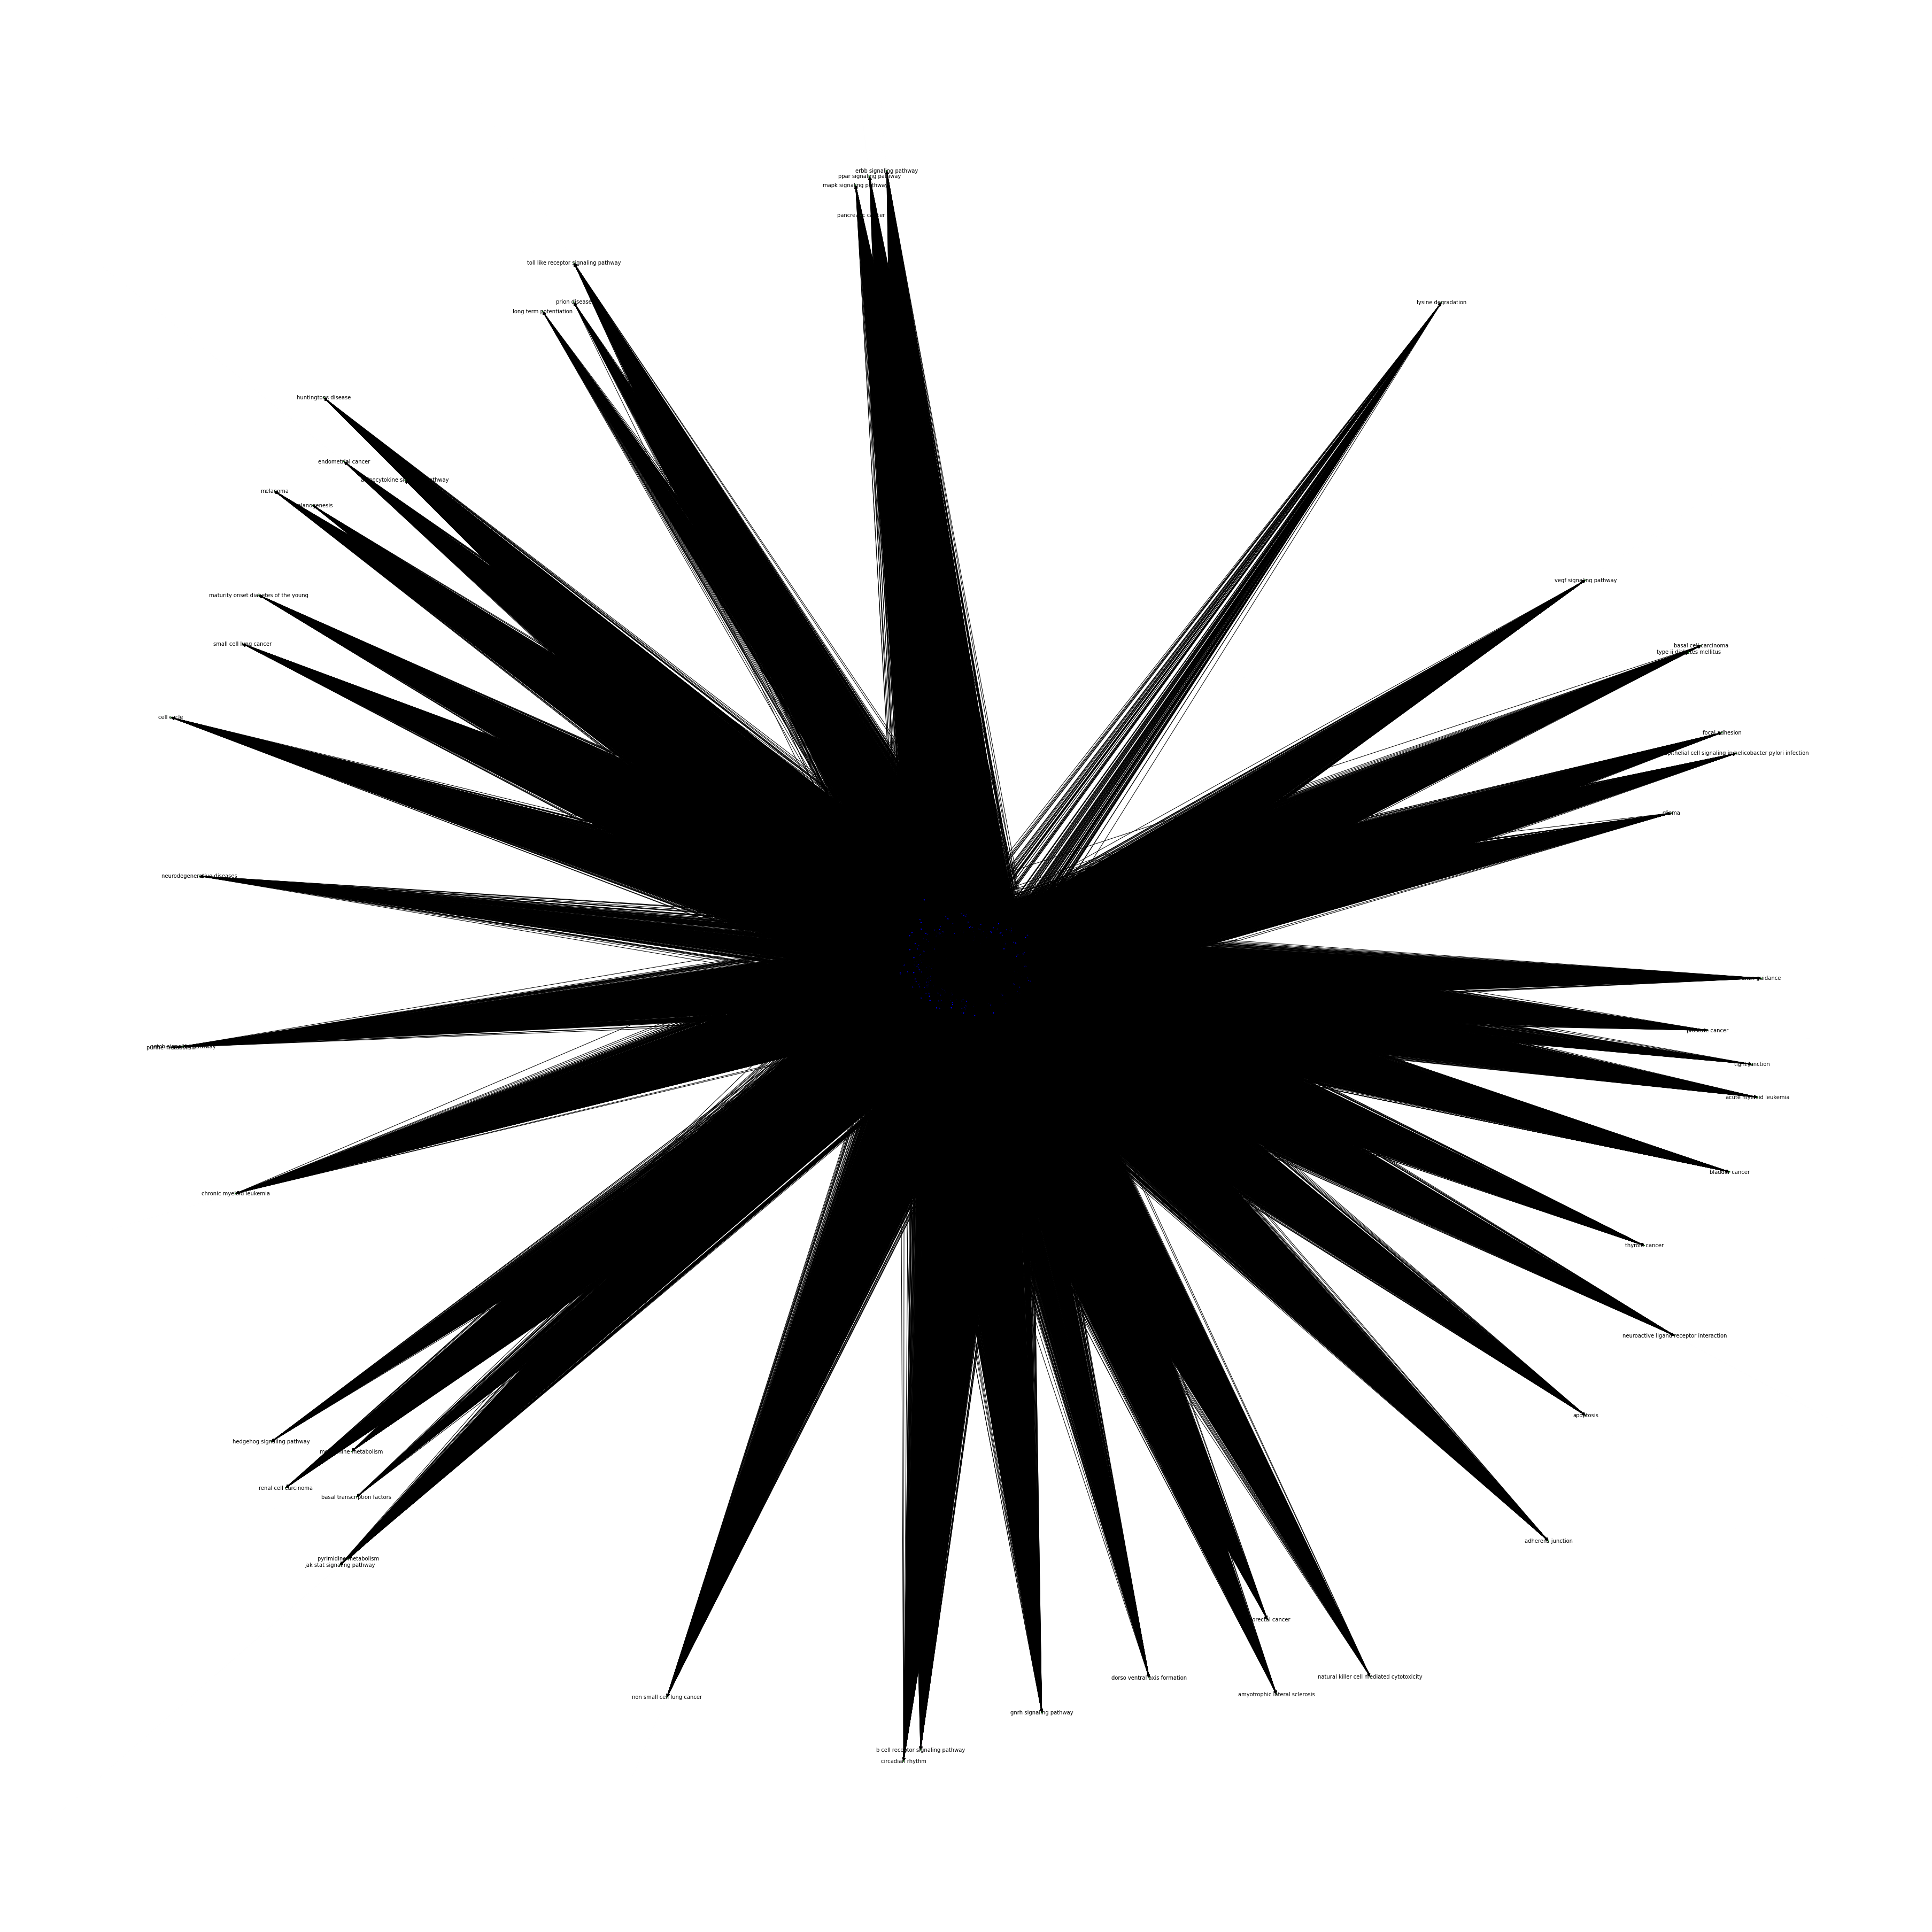

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import networkx as nx
import matplotlib.pyplot as plt

G2 = nx.from_pandas_edgelist(df, source='source', target='target', \
    create_using=nx.DiGraph)
colors = []
for node in G2:
    if node in df["source"].values:
        colors.append("blue")
    else: colors.append("green")

# print(colors)
# ['lightblue', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen',
#  'lightblue', 'lightblue', 'lightgreen', 'lightblue', 'lightblue',
#  'lightblue', 'lightblue', 'lightgreen', 'lightgreen']

plt.figure(figsize=(50, 50))
# <Figure size 1500x1000 with 0 Axes>

nx.draw(G2, pos = nx.spring_layout(G2), \
    node_size=2, node_color=colors, \
    font_size=10, with_labels=True)
#font_weight='bold'
#linewidths=0.25
plt.savefig('tf_cascadid_colour_label_3.png')
plt.show()




In [11]:
import pickle
pickle.dump(G2, open('tmp/tf_cascadid_colour_label_3.txt', 'w'))

# graph = pickle.load(open('/tmp/tf_cascadid_colour_label.txt'))
# print dg.edges()

TypeError: write() argument must be str, not bytes

In [ ]:
nx.write_gexf(G2, "tmp/gephi/tf_cascadid_colour_label_3.gexf")

## Networkx

In [25]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [26]:
tuples = [tuple(x) for x in df.values]

In [27]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

# import networkx as nx
# import matplotlib.pyplot as plt
# import pandas as pd

# G = nx.from_pandas_edgelist(df, source='pathway', target='tfs', \
#     create_using=nx.DiGraph)
# colors = []
# for node in G:
#     if node in df["pathway"].values:
#         colors.append("red")
#     else: colors.append("blue")

# # print(colors)
# # ['lightblue', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen',
# #  'lightblue', 'lightblue', 'lightgreen', 'lightblue', 'lightblue',
# #  'lightblue', 'lightblue', 'lightgreen', 'lightgreen']

# plt.figure(figsize=(50, 50))
# # <Figure size 1500x1000 with 0 Axes>

# nx.draw(G, pos = nx.spring_layout(G), \
#     node_size=2, node_color=colors, \
#     font_size=10, font_weight='bold', with_labels=False)
# #linewidths=0.25
# plt.savefig('tfc_graph_colour.png')
# plt.show()


In [28]:
# plt.show()
# # plt.savefig('tfc_graph_colour.png')

In [29]:
# G.edges

# node2vec

In [30]:
!pip install -q node2vec

In [31]:
# G_copy=G

In [32]:
# #heting node and edge list
# nx.write_edgelist(G, "tfs.edges")

In [33]:
# print(len(G.nodes),len(G.edges))

In [34]:
# fb_nodes=G.nodes
# # load edges (or links)
# with open("tfs.edges") as f:
#     fb_links = f.read().splitlines() 

In [35]:
# fb_links=str(fb_links)
# fb_links

In [36]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []


node_list_1=df.pathway.values.tolist()
node_list_2=df.tfs.values.tolist()


fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

In [37]:
fb_df

node_1  \
0                             lysine degradation   
1                          methionine metabolism   
2                         vegf signaling pathway   
3                                  axon guidance   
4      natural killer cell mediated cytotoxicity   
...                                          ...   
42913                    notch signaling pathway   
42914                     vegf signaling pathway   
42915                           circadian rhythm   
42916                              axon guidance   
42917  natural killer cell mediated cytotoxicity   

                                                  node_2  
0                                    ['SETDB1', 'STAT3']  
1                                     ['STAT3', 'DNMT1']  
2                                    ['STAT3', 'NFATC2']  
3                                    ['STAT3', 'NFATC2']  
4                                    ['STAT3', 'NFATC2']  
...                                                  ...  
42913  ['HMGA2', 'SOX2', 'NANOG', 'POU5F1', 'SALL4', ...  
42914  ['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...  
42915  ['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...  
42916  ['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...  
42917  ['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...  

[42918 rows x 2 columns]

# EXPERIMENTS

In [38]:
ten_author_pairs = [tuple(x) for x in fb_df.values]

In [39]:
# from itertools import combinations

# elements = list(set([e for l in ten_author_pairs for e in l])) # find all unique elements

# complete_list = list(combinations(elements, 2)) # generate all possible combinations

# #convert to sets to negate the order

# set1 = [set(l) for l in ten_author_pairs]
# complete_set = [set(l) for l in complete_list]

# # find sets in `complete_set` but not in `set1`
# ten_unconnnected = [list(l) for l in complete_set if l not in set1]

# print(len(ten_author_pairs))
# print(len(ten_unconnnected))

In [40]:
# df = pd.DataFrame(ten_author_pairs, columns = ['u1','u2'])
# df_negative = pd.DataFrame(ten_unconnected, columns = ['u1','u2'])
# df['link'] = 1 #for connected pairs
# df_negative['link'] = 0 #for unconnected pairs

# df_new = pd.concat([df,df_negative])
df_new=fb_df
df_new = df_new.rename({'node_1': 'u1', 'node_2': 'u2'}, axis=1)
df_new.head()

u1                   u2
0                         lysine degradation  ['SETDB1', 'STAT3']
1                      methionine metabolism   ['STAT3', 'DNMT1']
2                     vegf signaling pathway  ['STAT3', 'NFATC2']
3                              axon guidance  ['STAT3', 'NFATC2']
4  natural killer cell mediated cytotoxicity  ['STAT3', 'NFATC2']

In [41]:
# build graph
G_data = nx.from_pandas_edgelist(df_new, "u1", "u2", create_using=nx.Graph())

#!pip install node2vec
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/9784 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [21:41<00:00, 26.04s/it]


In [43]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(df_new['u1'], df_new['u2'])]



TypeError: 'Word2Vec' object is not subscriptable

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), df_new['link'], 
                                            test_size = 0.3, 
                                            random_state = 35)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)
predictions = lr.predict_proba(xtest)
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, predictions[:,1])

In [ ]:
print("a")